In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

# Import modules containing classes and functions needed for the simulation
from src.model_ctrl import RenG,gain
from src.model_sys import TrackingRobot, DynamicObstacle
from src.plots import plot_traj_vs_time, plot_losses_tracking,plot_trajectories_tracking_dyn_obs
from src.loss_functions import f_loss_u, f_loss_states_tracking, f_loss_obst_dyn_tracking
from src.utils import set_params_tracking
from src.model_trk import OptimalTrajectory, ReferenceTrajectory, dlqr

Optimizing open-loop control trajectory...
Iteration 0, cost = 55804.2930
Iteration 50, cost = 1035.0920
Iteration 100, cost = 238.3819
Iteration 150, cost = 171.0767
Iteration 200, cost = 150.1880
Iteration 250, cost = 140.2413
Iteration 300, cost = 134.9513
Iteration 350, cost = 132.0407
Iteration 400, cost = 130.4300
Iteration 450, cost = 129.5401
Open-loop reference trajectory saved


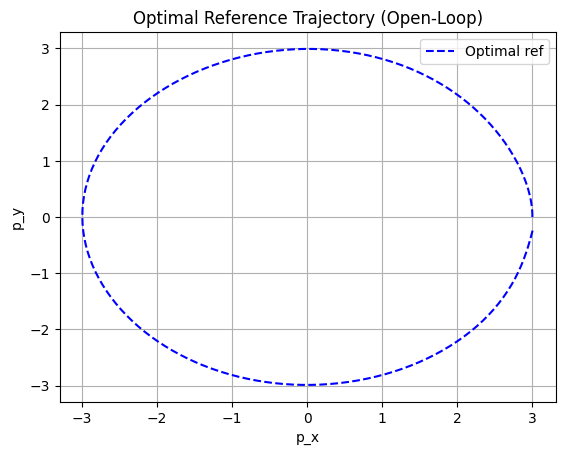

In [2]:
# 1. Parameters and Reference Trajectory Setup (similar to MATLAB code)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Ts = 0.05
b1 = 2
b2 = 0.5
A_np = np.array([[1, 0, Ts, 0],
                 [0, 1, 0, Ts],
                 [0, 0, 1 - Ts*b1, 0],
                 [0, 0, 0, 1 - Ts*b1]], dtype=np.float32)
B_np = np.array([[0, 0],
                 [0, 0],
                 [Ts, 0],
                 [0, Ts]], dtype=np.float32)
N = 300  # horizon length
T = np.linspace(0, N*Ts, N+1)
r = 3.0  # radius of semicircle
theta_ref = np.linspace(0, 2*math.pi, N+1)
computeTrajectory = True

# Desired semicircular positions
p_ref_des = np.vstack((r * np.cos(theta_ref), r * np.sin(theta_ref)))  # shape (2, N+1)
# Use finite differences to approximate velocity
dp_ref_des = np.gradient(p_ref_des, Ts, axis=1)
x_ref_des_np = np.vstack((p_ref_des, dp_ref_des)).T  # shape (N+1, 4)

# Convert to torch tensor
x_ref_des = torch.tensor(x_ref_des_np, dtype=torch.float32, device=device)

# Initial state (start at beginning of semicircle)
x0t = x_ref_des[0]

if computeTrajectory:
    # 2. Compute Optimal Trajectory using OptimalTrajectory class
    opt_traj_model = OptimalTrajectory(x0t, x_ref_des, Ts, b1, b2, N, device=device)
    print("Optimizing open-loop control trajectory...")
    u_opt, x_traj_opt = opt_traj_model.optimize(num_iters=500, lr=0.06, verbose=True)
    x_traj_opt_np = x_traj_opt.cpu().detach().numpy()
    np.save("trained_models/opt_traj_300_r3.npy",x_traj_opt_np)
    print("Open-loop reference trajectory saved")
else:
    x_traj_opt_np = np.load("trained_models/opt_traj_300_r3.npy")
    print("Open-loop reference trajectory loaded")

# Plot the computed reference trajectory (positions)
plt.figure()
plt.plot(x_traj_opt_np[:,0], x_traj_opt_np[:,1], 'b--', label='Optimal ref')
plt.title("Optimal Reference Trajectory (Open-Loop)")
plt.xlabel("p_x")
plt.ylabel("p_y")
plt.legend()
plt.grid(True)
plt.show()



# 3. Create a ReferenceTrajectory instance
ref_traj = ReferenceTrajectory(x_traj_opt_np, 1)

# 4. LQR Design for Tracking (using linearized error dynamics)
# Define matrices A and B (same as MATLAB)
# LQR weights (as in MATLAB code)
Q = 0.5 * np.eye(4, dtype=np.float32)
R = 0.05 * np.eye(2, dtype=np.float32)
K = dlqr(A_np, B_np, Q, R)  # returns torch tensor

# Convert A and B to torch tensors
A_t = torch.tensor(A_np, dtype=torch.float32, device=device)
B_t = torch.tensor(B_np, dtype=torch.float32, device=device)

# 5. Create ClosedLoopSystem instance
syst = TrackingRobot(A_t, B_t, K, Ts, b2, device=device)

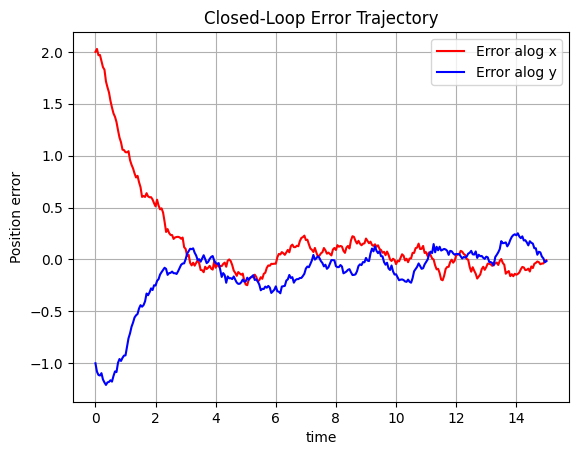

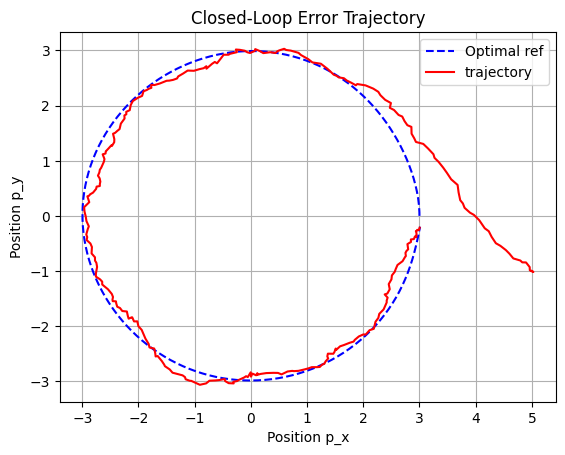

In [3]:
# 6. Closed-Loop Simulation with Process Noise and additional input u2.
# For demonstration, we simulate for N steps. We use the optimal open-loop control as u_ref
# and assume that the tracking controller is: u = u_ref - K*(x - x_ref) + u2.
# Here we simulate the error dynamics (x_error = x - x_ref). For simplicity, we assume
# that at t=0 the error is zero.
Nsim = N
x0 = torch.tensor([5,-1.0,0,0])
# Initial state (start at beginning of semicircle)
x0t = x_ref_des[0]
x_error = x0 - x0t  # start at zero error
x =  x0 - x0t + torch.tensor(ref_traj.get_reference(0), dtype=torch.float32, device=device)
x_error_traj = [x_error.unsqueeze(0)]
x_traj = [x.unsqueeze(0)]

# Let u2 be zero throughout for now.
u2 = torch.zeros(2, device=device)

# Process noise standard deviation:
w_std = 0.03
w_obs = 0.01
# Amplitude frequency and initial position obstacles
Aobs = 1.2
fobs = 1/20
init_pos1 = 3.0
init_pos2 = -3.0
np.random.seed(69)

for k in range(Nsim):
    # Get current reference (error reference is zero)
    # (In a more detailed simulation you would compute the tracking error between
    #  the current state and the reference state provided by ref_traj.)
    # Here we simulate the error dynamics directly.
    t_current = k
    # Sample noise:
    w = torch.tensor(w_std * np.random.randn(4), dtype=torch.float32, device=device)
    # Simulate one step:
    x_error = syst.forward(t_current, x_error, u2, w)
    x = x_error+ torch.tensor(ref_traj.get_reference(k+1), dtype=torch.float32, device=device)
    x_error_traj.append(x_error.unsqueeze(0))
    x_traj.append(x.unsqueeze(0))            
    

x_error_traj2 = torch.cat(x_error_traj, dim=0).cpu().detach().numpy()
x_traj2 = torch.cat(x_traj, dim=0).cpu().detach().numpy()
# Plot the error trajectory (positions)
plt.figure()
plt.plot(T, x_error_traj2[:,0], 'r-', label='Error alog x')
plt.plot(T, x_error_traj2[:,1], 'b-', label='Error alog y')
plt.title("Closed-Loop Error Trajectory")
plt.xlabel("time")
plt.ylabel("Position error")
plt.legend()
plt.grid(True)
plt.show()


plt.figure()
plt.plot(x_traj_opt_np[:,0], x_traj_opt_np[:,1], 'b--', label='Optimal ref')
plt.plot(x_traj2[:,0], x_traj2[:,1], 'r-', label='trajectory')
plt.title("Closed-Loop Error Trajectory")
plt.xlabel("Position p_x")
plt.ylabel("Position p_y")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Set the random seed for reproducibility
torch.manual_seed(1)
# Set the parameters and hyperparameters for the simulation
params = set_params_tracking()
min_dist, t_end, n_agents, learning_rate, epochs, Q, alpha_u, alpha_ca, alpha_obst, n_xi, \
l, n_traj, std_ini, gamma_bar, wmax, decayw,maxtimew = params

------- Print open loop trajectories --------


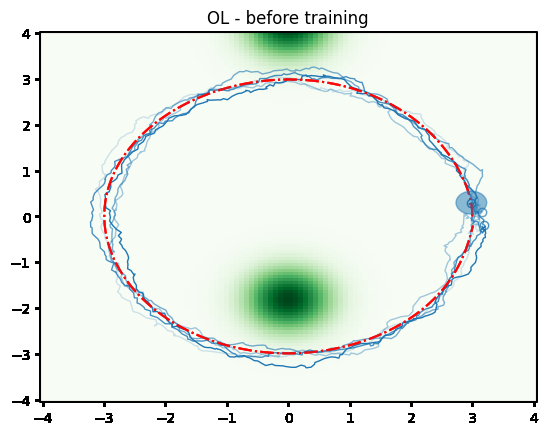

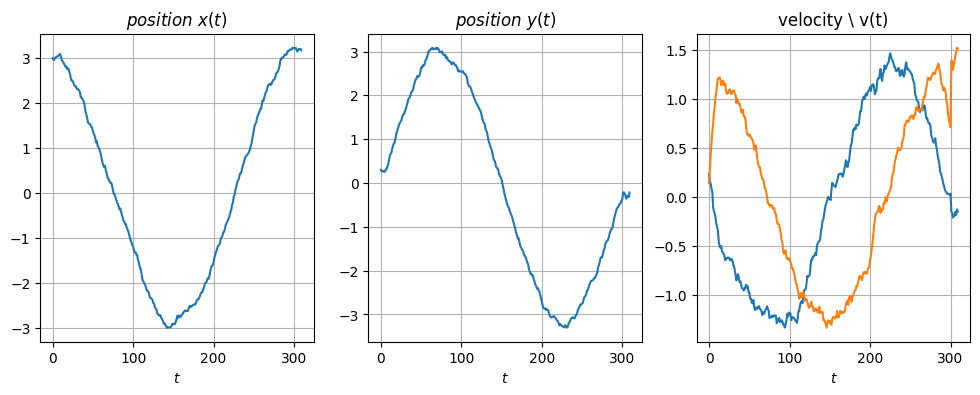

In [5]:
# Define the system and controller
amplifier = gain(gamma_bar)
ctl = RenG(syst.n, syst.m, n_xi, l, bias=False, mode="l2stable", gamma=1)

# Define the optimizer and its parameters
optimizer = torch.optim.Adam([
                {'params': ctl.parameters()},
                {'params': amplifier.parameters(), 'lr': 1e-1}], lr=learning_rate)

time = torch.linspace(0, t_end, t_end+1)
x0 = torch.tensor([3,0.0,0,0])
# Initial state (start at beginning of semicircle)
x0t = x_ref_des[0]
# Plot and log the open-loop trajectories before training
print("------- Print open loop trajectories --------")
loss_log = torch.zeros((t_end, 1, n_traj))
x_log = torch.zeros((t_end, syst.n, n_traj))
u = torch.zeros(syst.m)
with torch.no_grad():
    for traj in range(n_traj):
        dynamic_obstacle = DynamicObstacle(amplitude=Aobs, frequency=fobs, init_pos = init_pos1, phase=torch.randn(1).item(), noise_level=w_obs, device=device)
        dynamic_obstacle2 = DynamicObstacle(amplitude=Aobs, frequency=-fobs, init_pos = init_pos2, phase=torch.randn(1).item(), noise_level=w_obs, device=device)
        x = x0 + std_ini * torch.randn(x0.shape)
        x_error = x - x0t  # start 
        w_in = w_std * torch.randn((t_end + 1, syst.n))
        for t in range(t_end):
            obstacle_pos1 = dynamic_obstacle.update_position(dt=Ts)
            obstacle_pos2 = dynamic_obstacle2.update_position(dt=Ts)
            obstacle_pos = torch.cat((obstacle_pos1,obstacle_pos2),dim=0)
            x = x_error + torch.tensor(ref_traj.get_reference(t), dtype=torch.float32, device=device)
            x_log[t, :,traj] = x
            w_syst = w_in[t,:]
            x_error = syst.forward(t, x_error, u, w_syst)
            loss_x =  f_loss_states_tracking(t, x, syst,x_traj_opt_np, Q)
            loss_u = alpha_u * f_loss_u(t, u)
            if alpha_obst != 0:
                loss_obst =  alpha_obst * f_loss_obst_dyn_tracking(x,obstacle_pos)
            loss = loss_x + loss_u + loss_obst
            loss_log[t,:,traj] = loss

plot_trajectories_tracking_dyn_obs(x_log, x_traj_opt_np, syst.n_agents,obstacle_pos, text="OL - before training", T=t_end, obst=alpha_obst)
plot_traj_vs_time(t_end, syst.n_agents, x_log[:,:,0])

------------ Begin training ------------
Problem: RH neurSLS -- t_end: 310 -- lr: 1.00e-03 -- epochs: 1200 -- n_traj: 5 -- std_ini: 0.20 -- sym time: 15.5 s
 -- alpha_u: 0.1 -- alpha_ca: 100 -- alpha_obst: 1.0e+03
REN info -- n_xi: 8 -- l: 8
--------- --------- ---------  ---------
Epoch: 0 --- Loss: 45157.0898 ---||--- Loss x: 487.13 --- Loss u: 27.47 --- Loss obst: 44642.49
Epoch: 200 --- Loss: 31253.9395 ---||--- Loss x: 2665.96 --- Loss u: 216.98 --- Loss obst: 28371.00
Epoch: 400 --- Loss: 11147.9941 ---||--- Loss x: 6248.37 --- Loss u: 385.08 --- Loss obst: 4514.54
Epoch: 600 --- Loss: 14483.0117 ---||--- Loss x: 5968.76 --- Loss u: 418.20 --- Loss obst: 8096.05
Epoch: 800 --- Loss: 15273.5635 ---||--- Loss x: 6933.60 --- Loss u: 487.03 --- Loss obst: 7852.93
Epoch: 1000 --- Loss: 40239.9805 ---||--- Loss x: 8895.17 --- Loss u: 520.33 --- Loss obst: 30824.47


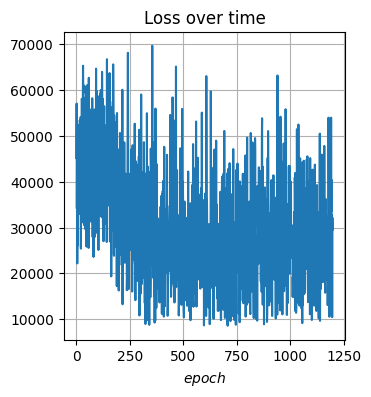

In [6]:
# # # # # # # # Train # # # # # # # #
# Train the controller using the NeurSLS algorithm
sim_time = t_end*syst.Ts
print("------------ Begin training ------------")
print("Problem: RH neurSLS -- t_end: %i" % t_end + " -- lr: %.2e" % learning_rate +
      " -- epochs: %i" % epochs + " -- n_traj: %i" % n_traj + " -- std_ini: %.2f" % std_ini + " -- sym time: %.1f s" % sim_time)
print(" -- alpha_u: %.1f" % alpha_u + " -- alpha_ca: %i" % alpha_ca + " -- alpha_obst: %.1e" % alpha_obst)
print("REN info -- n_xi: %i" % n_xi + " -- l: %i" % l)
print("--------- --------- ---------  ---------")


# Initialize arrays to store the loss and its components for each epoch
loss_list = np.zeros(epochs)

# Loop over the specified number of epochs
for epoch in range(epochs):
    # Reset the gradients of the optimizer
    if epoch > 0:
        del x,x_error,w_in,xi,w_REN,u,usys,loss, dynamic_obstacle, dynamic_obstacle2
    optimizer.zero_grad()
    # Initialize the loss and its components for this epoch
    loss_x, loss_u, loss_obst = 0, 0, 0
    if epoch==700:
        learning_rate_new = learning_rate/10
        optimizer = torch.optim.Adam([
                {'params': ctl.parameters()},
                {'params': amplifier.parameters(), 'lr': 1e-1}], lr=learning_rate_new)
    # Loop over the specified number of trajectories
    for kk in range(n_traj):
        dynamic_obstacle = DynamicObstacle(amplitude=Aobs, frequency=fobs, init_pos = init_pos1, phase=torch.randn(1).item(), noise_level=w_obs, device=device)
        dynamic_obstacle2 = DynamicObstacle(amplitude=Aobs, frequency=-fobs, init_pos = init_pos2, phase=torch.randn(1).item(), noise_level=w_obs, device=device)
        devx0 = std_ini * torch.randn(x0.shape)
        x = x0 + devx0
        x_error = x - x0t  # start 
        w_in = w_std * torch.randn((t_end + 1, syst.n))
        xi = torch.zeros(ctl.n)
        w_REN = x_error
        u, xi = ctl(0, w_REN, xi)
        usys = amplifier(u)
        for t in range(t_end):
            obstacle_pos1 = dynamic_obstacle.update_position(dt=Ts)
            obstacle_pos2 = dynamic_obstacle2.update_position(dt=Ts)
            obstacle_pos = torch.cat((obstacle_pos1,obstacle_pos2),dim=0)
            x = x_error+torch.tensor(ref_traj.get_reference(t))
            w_syst = w_in[t,:]
            x_error = syst.forward(t, x_error, usys, w_syst)
            w_REN = w_syst
            u, xi = ctl(t, w_REN, xi)
            usys = amplifier(u)
            # Compute the loss and its components for this time step
            loss_x =  loss_x + f_loss_states_tracking(t, x, syst,x_traj_opt_np, Q)
            loss_u = loss_u + alpha_u * f_loss_u(t, usys)
            if alpha_obst != 0:
                loss_obst = loss_obst + alpha_obst * f_loss_obst_dyn_tracking(x,obstacle_pos)

    # Compute the total loss for this epoch and log its components
    loss = loss_x + loss_u + loss_obst
    
    loss_list[epoch] = loss.detach()

    # Backpropagate the loss through the controller model and update its parameters
    loss.backward(retain_graph=True)
    optimizer.step()
    ctl.set_param()
    if epoch % 200 == 0:
        print("Epoch: %i --- Loss: %.4f ---||--- Loss x: %.2f --- " % (epoch, loss, loss_x) +
              "Loss u: %.2f --- Loss obst: %.2f" % (loss_u, loss_obst))


# Save the trained models to files
torch.save(ctl.state_dict(), "trained_models/offline_obstacles_ctl.pt")
torch.save(optimizer.state_dict(), "trained_models/offline_obstacles_opt.pt")
torch.save(amplifier.state_dict(), "trained_models/offline_obstacles_amp.pt")

t = torch.linspace(0, epochs - 1, epochs)
plt.figure(figsize=(4 * 2, 4))
plt.subplot(1, 2, 1)
plt.plot(t, loss_list[:])
plt.grid()
plt.xlabel(r'$epoch$')
plt.title('Loss over time')
plt.show()

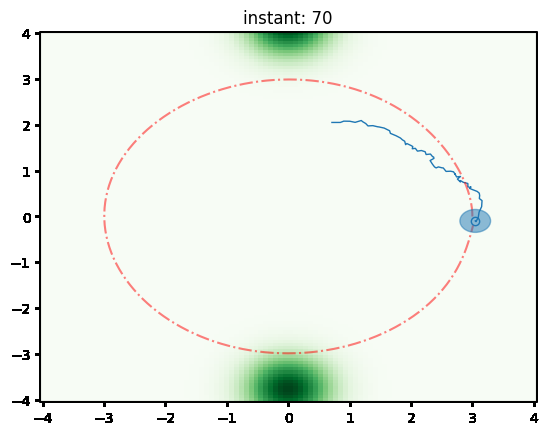

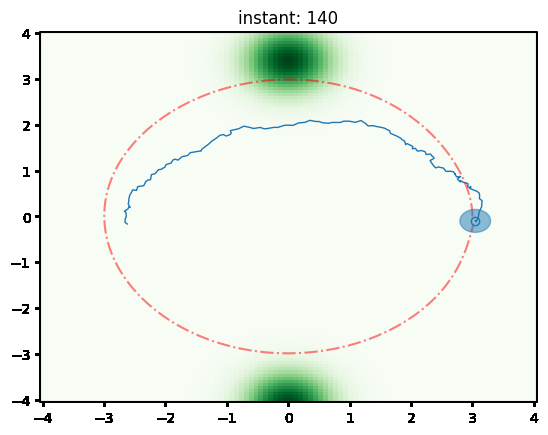

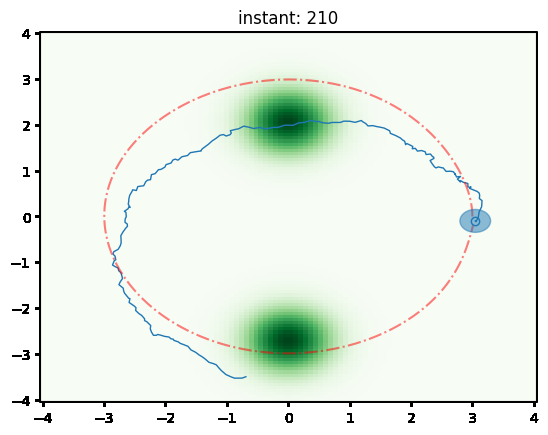

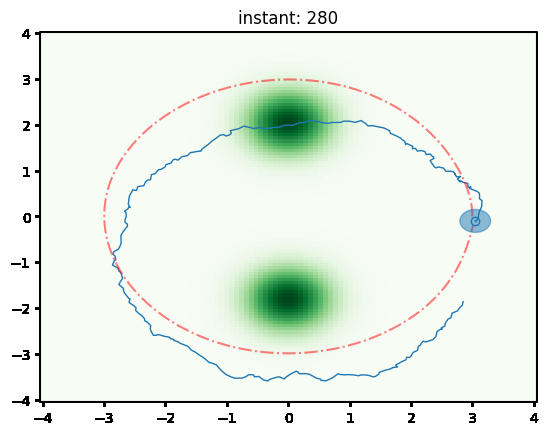

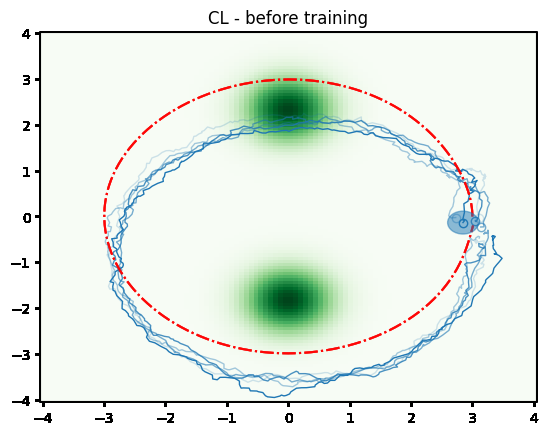

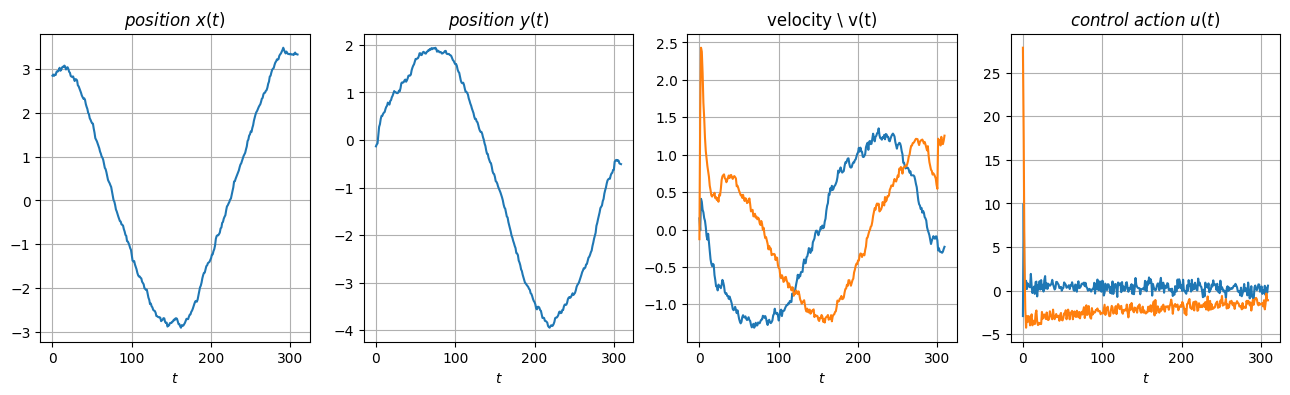

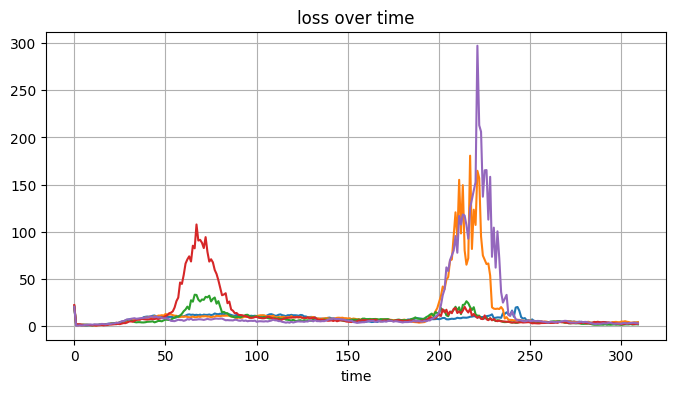

In [7]:
amplifier = gain(gamma_bar)
ctl = RenG(syst.n, syst.m, n_xi, l, bias=False, mode="l2stable", gamma=1)

ctl.load_state_dict(torch.load("trained_models/offline_obstacles_ctl.pt", weights_only=False))
ctl.set_param()
amplifier.load_state_dict(torch.load("trained_models/offline_obstacles_amp.pt", weights_only=False))

# Set the random seed for reproducibility
torch.manual_seed(99)

x_log = torch.zeros(t_end, syst.n, n_traj)
u_log = torch.zeros(t_end, syst.m, n_traj)
loss_log = torch.zeros((t_end, 1, n_traj))

with torch.no_grad():
    for traj in range(n_traj):
        dynamic_obstacle = DynamicObstacle(amplitude=Aobs, frequency=fobs, init_pos = init_pos1, phase=torch.randn(1).item(), noise_level=w_obs, device=device)
        dynamic_obstacle2 = DynamicObstacle(amplitude=Aobs, frequency=-fobs, init_pos = init_pos2, phase=torch.randn(1).item(), noise_level=w_obs, device=device)
        devx0 = std_ini * torch.randn(x0.shape)
        w_in = w_std * torch.randn((t_end + 1, syst.n))
        # Compute the closed-loop trajectories using the trained controller and plot them
        x = x0 + devx0
        x_error = x - x0t  # start
        xi = torch.zeros(ctl.n)
        w_REN = x_error
        u, xi = ctl(0, w_REN, xi)
        usys = amplifier(u)
        for t in range(t_end):
            obstacle_pos1 = dynamic_obstacle.update_position(dt=Ts)
            obstacle_pos2 = dynamic_obstacle2.update_position(dt=Ts)
            obstacle_pos = torch.cat((obstacle_pos1,obstacle_pos2),dim=0)
            x = x_error+torch.tensor(ref_traj.get_reference(t))
            x_log[t, :,traj] = (x_error+torch.tensor(ref_traj.get_reference(t))).detach()
            u_log[t, :,traj] = usys.detach()
            w_syst = w_in[t,:]
            x_error = syst.forward(t, x_error, usys, w_syst)
            w_REN = w_syst
            u, xi = ctl(t, w_REN, xi)
            usys = amplifier(u)
            # Compute the loss and its components for this time step
            loss_x =  f_loss_states_tracking(t, x, syst,x_traj_opt_np, Q)
            loss_u = alpha_u * f_loss_u(t, usys)
            if alpha_obst != 0:
                loss_obst =  alpha_obst * f_loss_obst_dyn_tracking(x,obstacle_pos)
            loss = loss_x + loss_u + loss_obst
            loss_log[t,:,traj] = loss.detach()
            if (t%70==0 and traj ==1 and t >0):
                plot_trajectories_tracking_dyn_obs(x_log[:t, :,traj], x_traj_opt_np, syst.n_agents,obstacle_pos, text="instant: %i"%t, T=t_end, obst=alpha_obst)


plot_trajectories_tracking_dyn_obs(x_log, x_traj_opt_np, syst.n_agents,obstacle_pos, text="CL - before training", T=t_end, obst=alpha_obst)
plot_traj_vs_time(t_end, syst.n_agents, x_log[:,:,0], u_log[:,:,0])

time = torch.linspace(0, t_end, t_end+1)
plt.figure(figsize=(4 * 2, 4))
for traj in range(n_traj):
    plt.plot(time[:t_end], loss_log[:,:,traj])
plt.xlabel('time')
plt.title('loss over time')
plt.grid()
plt.show()